In [1]:
import pennylane as qml
import pennylane.numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import json

In [4]:
import vqd

In [5]:
d_observables = qml.data.Dataset()
d_observables.read('observable_results_v2.dat')

In [6]:
# only the n_qubits value actually matters here since we're not doing optimization
# but the VQD class takes them all during instantiation
total_time = 2.0
#total_time = 0.5
dt = 0.05
max_iterations = 500
cost_threshold = 0.0001
n_qubits = 3 # this needs to be 3, however!
interface = 'autograd'

In [7]:
device_type = "qiskit.ibmq" # change this to run on real device

In [8]:
backend="ibmq_qasm_simulator"

# dev = qml.device(device_type, wires=n_qubits, backend=backend, 
#                               hub='qhack-event', group='main', project='level-1',
#                  ibmqx_token='') #insert token string!!

dev = qml.device(device_type, wires=n_qubits, backend=backend, 
                 ibmqx_token='') #insert token string!!

In [22]:
shots = 800 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.44573223e-02  4.44159251e-02  4.44573223e-02  7.11930567e-05
  7.11930567e-05  1.10530260e-03  2.20991500e-03  1.10530260e-03
 -2.51179964e-07 -2.51179964e-07  4.44573063e-02  4.44158613e-02
  4.44573063e-02  7.14097268e-05  7.14097268e-05  1.10594544e-03
  2.21120030e-03  1.10594544e-03]
running circuits

time :0.05
circuit params
[0.08887894 0.08869013 0.08887894 0.00047088 0.00047088 0.00312916
 0.00625284 0.00312916 0.00012174 0.00012174 0.08887848 0.08868833
 0.08887848 0.00060053 0.00060053 0.00313885 0.00627215 0.00313885]
running circuits

time :0.1
circuit params
[0.13324821 0.13275736 0.13324821 0.00139803 0.00139803 0.00593299
 0.01184635 0.00593299 0.00045527 0.00045527 0.1332452  0.13274576
 0.1332452  0.00189683 0.00189683 0.00597905 0.0119378  0.00597905]
running circuits

time :0.15000000000000002
circuit params
[0.17755394 0.17657415 0.17755394 0.00297788 0.00297788 0.00933848
 0.01862834 0.00933848 0.00104267 0.00104267 0.17754287 0.176532

In [23]:
def get_total_mag(results, shots):
    sig_x = np.tensor(results['observables'])[:,:3]
    sig_z = np.tensor(results['observables'])[:,3:]
    std_sig_x = np.sqrt(np.tensor(results['variances'])[:,:3]/shots)
    std_sig_z = np.sqrt(np.tensor(results['variances'])[:,3:]/shots)

    sum_sig_x = np.sum(sig_x, axis=1)
    sum_sig_z = np.sum(sig_z, axis=1)
    sum_sig_x_std = np.sqrt(np.sum(std_sig_x**2, axis=1))
    sum_sig_z_std = np.sqrt(np.sum(std_sig_z**2, axis=1))
    
    return sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std

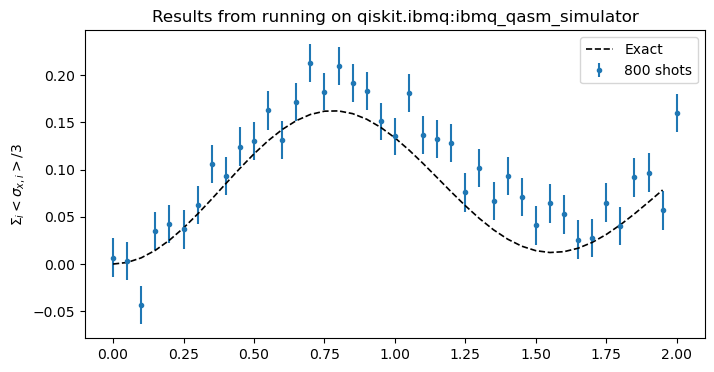

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()


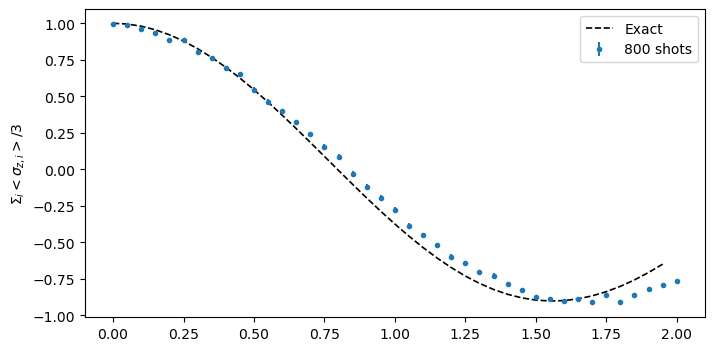

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_z/3, sum_sig_z_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{z,i}>/3$')

exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sz'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.legend()

In [26]:
shots = 8000 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.44573223e-02  4.44159251e-02  4.44573223e-02  7.11930567e-05
  7.11930567e-05  1.10530260e-03  2.20991500e-03  1.10530260e-03
 -2.51179964e-07 -2.51179964e-07  4.44573063e-02  4.44158613e-02
  4.44573063e-02  7.14097268e-05  7.14097268e-05  1.10594544e-03
  2.21120030e-03  1.10594544e-03]
running circuits

time :0.05
circuit params
[0.08887894 0.08869013 0.08887894 0.00047088 0.00047088 0.00312916
 0.00625284 0.00312916 0.00012174 0.00012174 0.08887848 0.08868833
 0.08887848 0.00060053 0.00060053 0.00313885 0.00627215 0.00313885]
running circuits

time :0.1
circuit params
[0.13324821 0.13275736 0.13324821 0.00139803 0.00139803 0.00593299
 0.01184635 0.00593299 0.00045527 0.00045527 0.1332452  0.13274576
 0.1332452  0.00189683 0.00189683 0.00597905 0.0119378  0.00597905]
running circuits

time :0.15000000000000002
circuit params
[0.17755394 0.17657415 0.17755394 0.00297788 0.00297788 0.00933848
 0.01862834 0.00933848 0.00104267 0.00104267 0.17754287 0.176532

In [27]:
# plotting tools

In [28]:
def get_total_mag(results, shots):
    sig_x = np.tensor(results['observables'])[:,:3]
    sig_z = np.tensor(results['observables'])[:,3:]
    std_sig_x = np.sqrt(np.tensor(results['variances'])[:,:3]/shots)
    std_sig_z = np.sqrt(np.tensor(results['variances'])[:,3:]/shots)

    sum_sig_x = np.sum(sig_x, axis=1)
    sum_sig_z = np.sum(sig_z, axis=1)
    sum_sig_x_std = np.sqrt(np.sum(std_sig_x**2, axis=1))
    sum_sig_z_std = np.sqrt(np.sum(std_sig_z**2, axis=1))
    
    return sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std

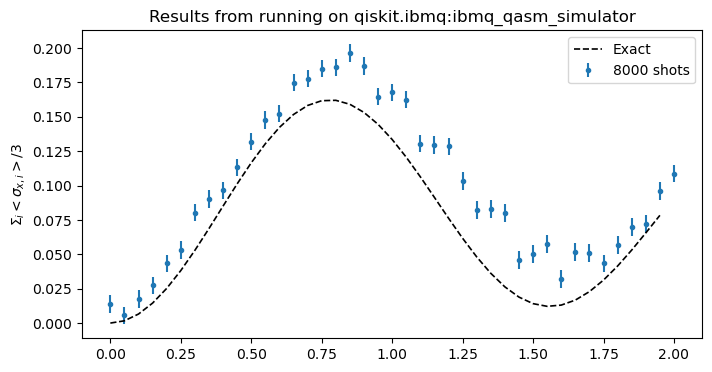

In [29]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()


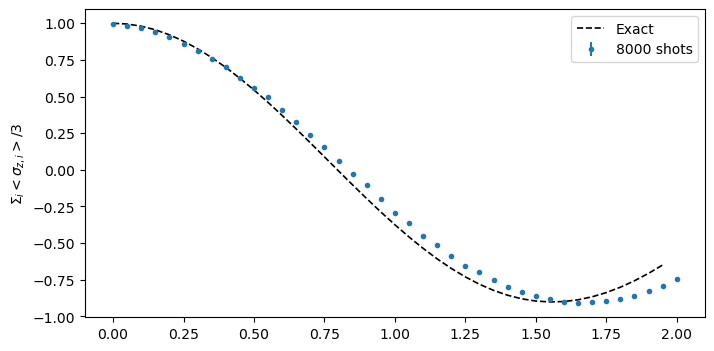

In [30]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_z/3, sum_sig_z_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{z,i}>/3$')

exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sz'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.legend()

In [31]:
shots = 80 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.44573223e-02  4.44159251e-02  4.44573223e-02  7.11930567e-05
  7.11930567e-05  1.10530260e-03  2.20991500e-03  1.10530260e-03
 -2.51179964e-07 -2.51179964e-07  4.44573063e-02  4.44158613e-02
  4.44573063e-02  7.14097268e-05  7.14097268e-05  1.10594544e-03
  2.21120030e-03  1.10594544e-03]
running circuits

time :0.05
circuit params
[0.08887894 0.08869013 0.08887894 0.00047088 0.00047088 0.00312916
 0.00625284 0.00312916 0.00012174 0.00012174 0.08887848 0.08868833
 0.08887848 0.00060053 0.00060053 0.00313885 0.00627215 0.00313885]
running circuits

time :0.1
circuit params
[0.13324821 0.13275736 0.13324821 0.00139803 0.00139803 0.00593299
 0.01184635 0.00593299 0.00045527 0.00045527 0.1332452  0.13274576
 0.1332452  0.00189683 0.00189683 0.00597905 0.0119378  0.00597905]
running circuits

time :0.15000000000000002
circuit params
[0.17755394 0.17657415 0.17755394 0.00297788 0.00297788 0.00933848
 0.01862834 0.00933848 0.00104267 0.00104267 0.17754287 0.176532

In [32]:
shots = 20000 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[80000]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.44573223e-02  4.44159251e-02  4.44573223e-02  7.11930567e-05
  7.11930567e-05  1.10530260e-03  2.20991500e-03  1.10530260e-03
 -2.51179964e-07 -2.51179964e-07  4.44573063e-02  4.44158613e-02
  4.44573063e-02  7.14097268e-05  7.14097268e-05  1.10594544e-03
  2.21120030e-03  1.10594544e-03]
running circuits

time :0.05
circuit params
[0.08887894 0.08869013 0.08887894 0.00047088 0.00047088 0.00312916
 0.00625284 0.00312916 0.00012174 0.00012174 0.08887848 0.08868833
 0.08887848 0.00060053 0.00060053 0.00313885 0.00627215 0.00313885]
running circuits

time :0.1
circuit params
[0.13324821 0.13275736 0.13324821 0.00139803 0.00139803 0.00593299
 0.01184635 0.00593299 0.00045527 0.00045527 0.1332452  0.13274576
 0.1332452  0.00189683 0.00189683 0.00597905 0.0119378  0.00597905]
running circuits

time :0.15000000000000002
circuit params
[0.17755394 0.17657415 0.17755394 0.00297788 0.00297788 0.00933848
 0.01862834 0.00933848 0.00104267 0.00104267 0.17754287 0.176532

ERROR:websocket:Connection to remote host was lost. - goodbye



time :1.35
circuit params
[1.25811616 1.24090139 1.25811616 0.24429594 0.24429594 0.18953592
 0.36948692 0.18953592 0.13296406 0.13296406 1.28427936 1.24574826
 1.28427936 0.11305488 0.11305488 0.06580661 0.14169094 0.06580661]
running circuits

time :1.4000000000000001
circuit params
[1.30327958 1.28671151 1.30327958 0.25042339 0.25042339 0.19563518
 0.38067525 0.19563518 0.13676779 0.13676779 1.33553419 1.29847864
 1.33553419 0.1077186  0.1077186  0.05754574 0.12863899 0.05754574]
running circuits

time :1.4500000000000002
circuit params
[1.34772702 1.33118904 1.34772702 0.25464006 0.25464006 0.20064725
 0.38995386 0.20064725 0.14004304 0.14004304 1.38736318 1.35221099
 1.38736318 0.10170351 0.10170351 0.04800398 0.11283951 0.04800398]
running circuits

time :1.5
circuit params
[1.39104643 1.3737263  1.39104643 0.25706166 0.25706166 0.20450386
 0.39721456 0.20450386 0.14295909 0.14295909 1.43959341 1.40681775
 1.43959341 0.09534888 0.09534888 0.03718106 0.09398858 0.03718106]
runnin

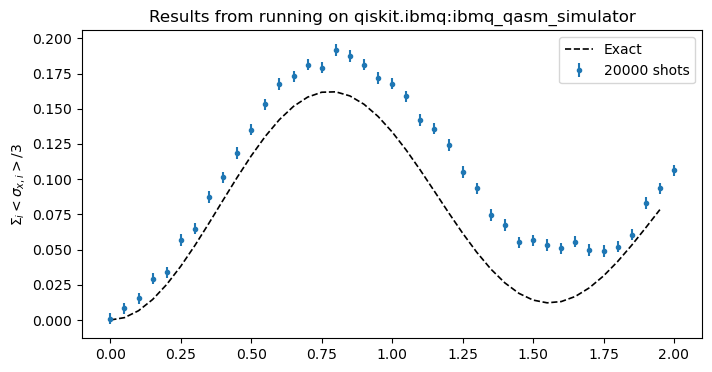

In [33]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()
